# Data prep

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler, StandardScaler, QuantileTransformer, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   

     mjd  fiberid  
0  54922      491  
1  51615      541  
2  52023      513

## Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


ra       dec         u        g         r         i         z  \
0  183.531326  0.089693  19.47406  17.0424  15.94699  15.50342  15.22531   

  class  redshift  
0  STAR -0.000009

## Split into train/test sets

In [4]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale the data

In [5]:
robust_scaler = RobustScaler()
normalizer = Normalizer()
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
quantile_transformer = QuantileTransformer(output_distribution="normal")
maxabs_scaler = MaxAbsScaler()

X_train_minmax_scaled = min_max_scaler.fit_transform(X_train.astype(np.float64))
X_test_minmax_scaled = min_max_scaler.fit_transform(X_test.astype(np.float64))

X_train_normalized = normalizer.fit_transform(X_train.astype(np.float64))
X_test_normalized = normalizer.fit_transform(X_test.astype(np.float64))

X_train_std_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
X_test_std_scaled = std_scaler.fit_transform(X_test.astype(np.float64))

X_train_rob_scaled = robust_scaler.fit_transform(X_train.astype(np.float64))
X_test_rob_scaled = robust_scaler.fit_transform(X_test.astype(np.float64))

X_train_maxabs_scaled = maxabs_scaler.fit_transform(X_train.astype(np.float64))
X_test_maxabs_scaled = maxabs_scaler.fit_transform(X_test.astype(np.float64))

X_train_q_scaled = quantile_transformer.fit_transform(X_train.astype(np.float64))
X_test_q_scaled = quantile_transformer.fit_transform(X_test.astype(np.float64))

data_sets = []

minmax_set = DataSet("MinMax Scaled", X_train_minmax_scaled, y_train, X_test_minmax_scaled, y_test)
normalized_set = DataSet("Normalized", X_train_normalized, y_train, X_test_normalized, y_test)
std_scaled_set = DataSet("Standard Scaled", X_train_std_scaled, y_train, X_test_std_scaled, y_test)
robust_scaled_set = DataSet("Robust Scaled", X_train_rob_scaled, y_train, X_test_rob_scaled, y_test)
quantile_set = DataSet("Quantile Transformed", X_train_q_scaled, y_train, X_test_q_scaled, y_test)
max_abs_set = DataSet("MaxABS Scaled", X_train_maxabs_scaled, y_train, X_test_maxabs_scaled, y_test)

data_sets.append(minmax_set)
data_sets.append(normalized_set)
data_sets.append(std_scaled_set)
data_sets.append(robust_scaled_set)
data_sets.append(quantile_set)
data_sets.append(max_abs_set)

# Classification

## Prepare result sets

In [6]:
result_sets = []

# Classfiers
knn_clf = KNeighborsClassifier()
svm_clf = SVC(gamma="auto", random_state=42)
lsvm_clf = LinearSVC(C=10, loss="hinge", random_state=42)
nusvm_clf = NuSVC(nu=0.05, gamma=0.1)
rbf_svm_clf = SVC(kernel="rbf", gamma=0.1, C=1000)
poly_svm_clf = SVC(kernel="poly", gamma="scale", degree=3, coef0=100, C=5)
tree_clf = DecisionTreeClassifier(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
log_clf = LogisticRegression(
    solver="liblinear", random_state=42, multi_class='auto')
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.05, 
                                    max_features=2, max_depth = 4, random_state = 42)
# Xgboost parameters
xgb_params = {'learning_rate': 0.05,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1,
              'n_estimators': 100,
              'gamma': 1,
              'min_child_weight': 4,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist'
              }
xgb_clf = XGBClassifier(**xgb_params, seed=42)
bag_df_clf = BaggingClassifier(
    DecisionTreeClassifier(
        splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
sgd_clf = SGDClassifier(max_iter=500, tol=-np.infty, random_state=42)
mlp_clf = MLPClassifier(random_state=42, max_iter=2000)
xtree_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
pa_clf = PassiveAggressiveClassifier(max_iter=5000, random_state=0, tol=1e-3)
r_clf = RidgeClassifier()
nb_clf = GaussianNB()
mnb_clf = MultinomialNB()
lda_clf = LinearDiscriminantAnalysis()
qda_clf = QuadraticDiscriminantAnalysis()
v_clf = VotingClassifier(estimators=[
    ("SVC", svm_clf),
    ("NuSVC", nusvm_clf),
    ("RbfSVC", rbf_svm_clf),
    ("PolySVC", poly_svm_clf),
    ("Tree", tree_clf),
    ("RF", rnd_clf),
    ("XGB", xgb_clf),
    ("Bagging", bag_df_clf),
    ("MLP", mlp_clf),
    ("XTrees", xtree_clf),
    ("NaiveBayes", nb_clf),
    ("QDA", qda_clf),
], voting="hard", n_jobs=-1)

# CLF names
clf_names = ["KNN",
             "SVC",
             "LinearSVM",
             "NuSVC", 
             "RbfKernelSVM", 
             "PolyKernelSVM",
             "DecisionTreeClassifier",
             "RandomForestClassifier", 
             "LogisticRegression", 
             "GradientBoostingClassifier", 
             "XGBClassifier", 
             "BaggingClassifier",
             "AdaBoostClassifier",
             "SGDClassifier",
             "MLPClassifier", 
             "ExtraTreesClassifier",
             "PassiveAggressiveClassifier",
             "RidgeClassifier",
             "GaussianNB", 
             "MultinomialNB", 
             "LinearDiscriminantAnalysis",
             "QuadraticDiscriminantAnalysis",
             "VotingClassifier"]

clfs = [knn_clf,
        svm_clf,
        lsvm_clf,
        nusvm_clf,
        rbf_svm_clf, 
        poly_svm_clf,
        tree_clf, 
        rnd_clf, 
        log_clf, 
        gb_clf,
        xgb_clf, 
        bag_df_clf,
        ada_clf,
        sgd_clf,
        mlp_clf, 
        xtree_clf,
        pa_clf,
        r_clf,
        nb_clf,
        mnb_clf,
        lda_clf,
        qda_clf, 
        v_clf]

## Run

Data Set Type:  MinMax Scaled
KNN
[0.87674883 0.84410393 0.87       0.84723149 0.85523682]
Accuracy: 0.859 (+/- 0.025)
KNN :
 [[1041    2  203]
 [  16  208   18]
 [ 185    2  825]]
              precision    recall  f1-score   support

      GALAXY       0.84      0.84      0.84      1246
         QSO       0.98      0.86      0.92       242
        STAR       0.79      0.82      0.80      1012

   micro avg       0.83      0.83      0.83      2500
   macro avg       0.87      0.84      0.85      2500
weighted avg       0.83      0.83      0.83      2500



SVC
[0.80279813 0.78880746 0.80733333 0.79786524 0.80253502]
Accuracy: 0.800 (+/- 0.013)
SVC :
 [[1077    0  169]
 [  21  176   45]
 [ 316    0  696]]
              precision    recall  f1-score   support

      GALAXY       0.76      0.86      0.81      1246
         QSO       1.00      0.73      0.84       242
        STAR       0.76      0.69      0.72      1012

   micro avg       0.78      0.78      0.78      2500
   macro avg 

ExtraTreesClassifier
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



PassiveAggressiveClassifier
[0.92271819 0.93137908 0.94066667 0.78719146 0.94596398]
Accuracy: 0.906 (+/- 0.119)
PassiveAggressiveClassifier :
 [[1091    3  152]
 [  29  213    0]
 [  81    0  931]]
              precision    recall  f1-score   support

      GALAXY       0.91      0.88      0.89      1246
         QSO       0.99      0.88      0.93       242
        STAR       0.86      0.92      0.89      1012

   micro avg   

{'GALAXY': 0.9064041615786145, 'QSO': 0.8817885351623979, 'STAR': 0.9197758617025799}


QuadraticDiscriminantAnalysis
{'GALAXY': 0.9859908965467806, 'QSO': 0.9859050282192242, 'STAR': 0.9925490883590463}


VotingClassifier
{'GALAXY': 0.9891934893413309, 'QSO': 0.9763869876801675, 'STAR': 0.9959677419354839}


Data Set Type:  Normalized
KNN
[0.80746169 0.80279813 0.80733333 0.79252835 0.81987992]
Accuracy: 0.806 (+/- 0.018)
KNN :
 [[992   5 249]
 [ 29 180  33]
 [270  16 726]]
              precision    recall  f1-score   support

      GALAXY       0.77      0.80      0.78      1246
         QSO       0.90      0.74      0.81       242
        STAR       0.72      0.72      0.72      1012

   micro avg       0.76      0.76      0.76      2500
   macro avg       0.79      0.75      0.77      2500
weighted avg       0.76      0.76      0.76      2500



SVC
[0.50233178 0.50099933 0.506      0.50366911 0.50166778]
Accuracy: 0.503 (+/- 0.004)
SVC :
 [[1244    0    2]
 [ 242    0    0]
 [101

MLPClassifier
[0.96335776 0.96402398 0.976      0.92194797 0.84589726]
Accuracy: 0.934 (+/- 0.096)
MLPClassifier :
 [[1134    0  112]
 [ 148   88    6]
 [ 588    0  424]]
              precision    recall  f1-score   support

      GALAXY       0.61      0.91      0.73      1246
         QSO       1.00      0.36      0.53       242
        STAR       0.78      0.42      0.55      1012

   micro avg       0.66      0.66      0.66      2500
   macro avg       0.80      0.56      0.60      2500
weighted avg       0.72      0.66      0.64      2500



ExtraTreesClassifier
[0.96135909 0.96402398 0.97333333 0.97464977 0.97731821]
Accuracy: 0.970 (+/- 0.013)
ExtraTreesClassifier :
 [[1209    6   31]
 [  22  219    1]
 [  32    0  980]]
              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96      1246
         QSO       0.97      0.90      0.94       242
        STAR       0.97      0.97      0.97      1012

   micro avg       0.96      0.96      0.96

KNN
[0.90206529 0.88607595 0.908      0.8945964  0.89793195]
Accuracy: 0.898 (+/- 0.015)
KNN :
 [[1060    2  184]
 [  12  218   12]
 [ 155    4  853]]
              precision    recall  f1-score   support

      GALAXY       0.86      0.85      0.86      1246
         QSO       0.97      0.90      0.94       242
        STAR       0.81      0.84      0.83      1012

   micro avg       0.85      0.85      0.85      2500
   macro avg       0.88      0.86      0.87      2500
weighted avg       0.85      0.85      0.85      2500



SVC
[0.9586942  0.95003331 0.966      0.9646431  0.96197465]
Accuracy: 0.960 (+/- 0.011)
SVC :
 [[1106    3  137]
 [  16  224    2]
 [  24    1  987]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.89      0.92      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.88      0.98      0.92      1012

   micro avg       0.93      0.93      0.93      2500
   macro avg       0.94      0.93      0.93

ExtraTreesClassifier
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



PassiveAggressiveClassifier
[0.96602265 0.93137908 0.97133333 0.94596398 0.9593062 ]
Accuracy: 0.955 (+/- 0.029)
PassiveAggressiveClassifier :
 [[1151   25   70]
 [  34  208    0]
 [ 104    2  906]]
              precision    recall  f1-score   support

      GALAXY       0.89      0.92      0.91      1246
         QSO       0.89      0.86      0.87       242
        STAR       0.93      0.90      0.91      1012

   micro avg   

{'GALAXY': 0.9895973334766947, 'QSO': 0.9743208719776884, 'STAR': 0.9966397849462366}


Data Set Type:  Robust Scaled
KNN
[0.96535643 0.9586942  0.96866667 0.96931288 0.96597732]
Accuracy: 0.966 (+/- 0.008)
KNN :
 [[1133    5  108]
 [  17  225    0]
 [  28    0  984]]
              precision    recall  f1-score   support

      GALAXY       0.96      0.91      0.93      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.90      0.97      0.94      1012

   micro avg       0.94      0.94      0.94      2500
   macro avg       0.95      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



SVC
[0.98067955 0.9733511  0.98466667 0.98599066 0.98332221]
Accuracy: 0.982 (+/- 0.009)
SVC :
 [[1198    3   45]
 [  16  226    0]
 [   0    2 1010]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.97      1246
         QSO       0.98      0.93      0.96       242
        STAR       0.96      1.00 

ExtraTreesClassifier
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



PassiveAggressiveClassifier
[0.97001999 0.96069287 0.91466667 0.97598399 0.97531688]
Accuracy: 0.959 (+/- 0.046)
PassiveAggressiveClassifier :
 [[1213   13   20]
 [  68  174    0]
 [  43    1  968]]
              precision    recall  f1-score   support

      GALAXY       0.92      0.97      0.94      1246
         QSO       0.93      0.72      0.81       242
        STAR       0.98      0.96      0.97      1012

   micro avg   

{'GALAXY': 0.9831819077827357, 'QSO': 0.9710725501248088, 'STAR': 0.9927071379999148}


LinearDiscriminantAnalysis
{'GALAXY': 0.9064041615786145, 'QSO': 0.8817885351623979, 'STAR': 0.9197758617025799}


QuadraticDiscriminantAnalysis
{'GALAXY': 0.9859908965467806, 'QSO': 0.9859050282192242, 'STAR': 0.9925490883590463}


VotingClassifier
{'GALAXY': 0.9892011694199749, 'QSO': 0.9722547562752087, 'STAR': 0.9964817353053678}


Data Set Type:  Quantile Transformed
KNN
[0.9586942  0.96069287 0.95733333 0.96731154 0.9593062 ]
Accuracy: 0.961 (+/- 0.007)
KNN :
 [[1168    8   70]
 [  12  230    0]
 [  30    1  981]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.94      0.95      1246
         QSO       0.96      0.95      0.96       242
        STAR       0.93      0.97      0.95      1012

   micro avg       0.95      0.95      0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



SVC

MLPClassifier
[0.98467688 0.97868088 0.98933333 0.99066044 0.98865911]
Accuracy: 0.986 (+/- 0.009)
MLPClassifier :
 [[1212    8   26]
 [  12  230    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.97      0.98      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.97      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.98      2500
weighted avg       0.98      0.98      0.98      2500



ExtraTreesClassifier
[0.97401732 0.97601599 0.98533333 0.97598399 0.98132088]
Accuracy: 0.979 (+/- 0.008)
ExtraTreesClassifier :
 [[1211    6   29]
 [  17  225    0]
 [  17    0  995]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97      1246
         QSO       0.97      0.93      0.95       242
        STAR       0.97      0.98      0.98      1012

   micro avg       0.97      0.97      0.97

{'GALAXY': 0.9519534280031029, 'QSO': 0.9732136974869885, 'STAR': 0.9611622890900591}


SVC
{'GALAXY': 0.971542108591192, 'QSO': 0.9752798131894678, 'STAR': 0.982546803944069}


LinearSVM
{'GALAXY': 0.9667574195959766, 'QSO': 0.959193757365913, 'STAR': 0.9790683836967148}


NuSVC
{'GALAXY': 0.9771933664600726, 'QSO': 0.9775673637900871, 'STAR': 0.9843663670364231}


RbfKernelSVM
{'GALAXY': 0.972807401547792, 'QSO': 0.970926146886369, 'STAR': 0.9810858408772154}


PolyKernelSVM
{'GALAXY': 0.9783920987350909, 'QSO': 0.9791906096962865, 'STAR': 0.9858685026987972}


DecisionTreeClassifier
{'GALAXY': 0.9819908555863612, 'QSO': 0.964801001398151, 'STAR': 0.9956715648773853}


RandomForestClassifier
{'GALAXY': 0.9892037294461895, 'QSO': 0.9722547562752087, 'STAR': 0.9963236856644992}


LogisticRegression
{'GALAXY': 0.9563368328891687, 'QSO': 0.9672367852776904, 'STAR': 0.9687314059246036}


GradientBoostingClassifier
{'GALAXY': 0.989602453529124, 'QSO': 0.9740994370795483, 'STAR': 0.99665970

BaggingClassifier
[0.98201199 0.9793471  0.986      0.98599066 0.98799199]
Accuracy: 0.984 (+/- 0.006)
BaggingClassifier :
 [[1232    4   10]
 [  13  229    0]
 [   0    0 1012]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



AdaBoostClassifier
[0.67954697 0.93404397 0.68066667 0.82054703 0.74116077]
Accuracy: 0.771 (+/- 0.193)
AdaBoostClassifier :
 [[1223   16    7]
 [ 125  117    0]
 [ 151    0  861]]
              precision    recall  f1-score   support

      GALAXY       0.82      0.98      0.89      1246
         QSO       0.88      0.48      0.62       242
        STAR       0.99      0.85      0.92      1012

   micro avg       0.88      0.88      

{'GALAXY': 0.9767920823509232, 'QSO': 0.9679010899721101, 'STAR': 0.9846625440945217}


PassiveAggressiveClassifier
{'GALAXY': 0.8360258409046109, 'QSO': 0.9645795665000111, 'STAR': 0.8673737727910238}


RidgeClassifier
{'GALAXY': 0.8113260679789361, 'QSO': 0.8820099700605377, 'STAR': 0.7873395596922946}


GaussianNB
{'GALAXY': 0.9831819077827357, 'QSO': 0.9710725501248088, 'STAR': 0.9927071379999148}


LinearDiscriminantAnalysis
{'GALAXY': 0.9064041615786145, 'QSO': 0.8817885351623979, 'STAR': 0.9197758617025799}


QuadraticDiscriminantAnalysis
{'GALAXY': 0.9859908965467806, 'QSO': 0.9859050282192242, 'STAR': 0.9925490883590463}


VotingClassifier
{'GALAXY': 0.989602453529124, 'QSO': 0.9722547562752087, 'STAR': 0.9968177568107441}




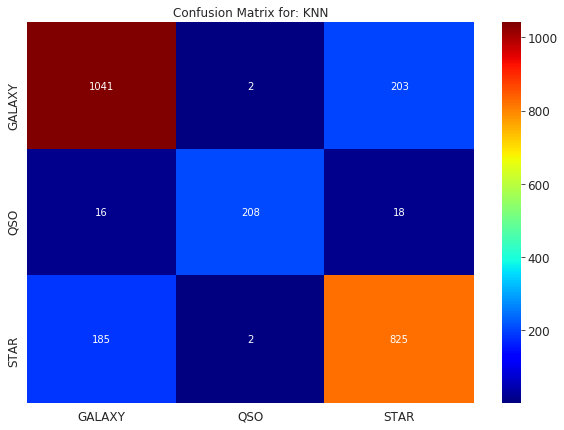

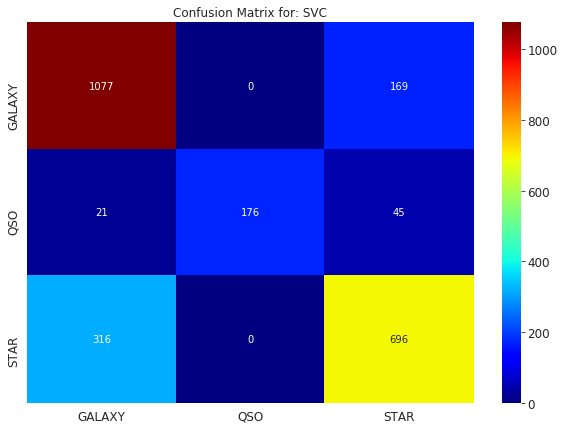

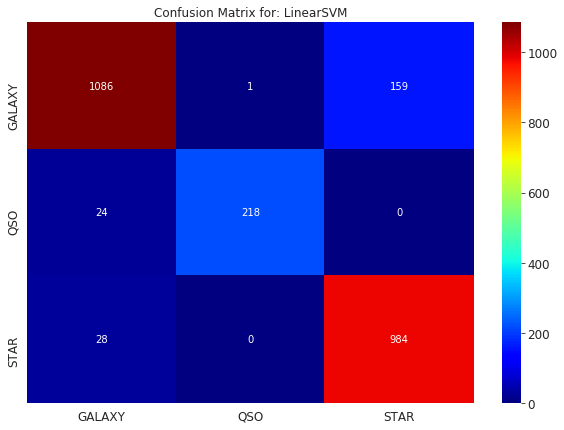

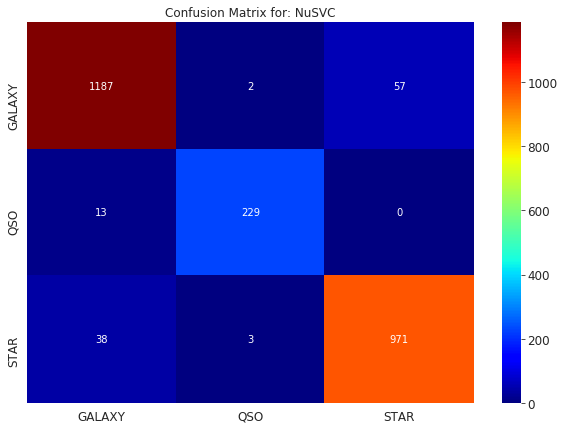

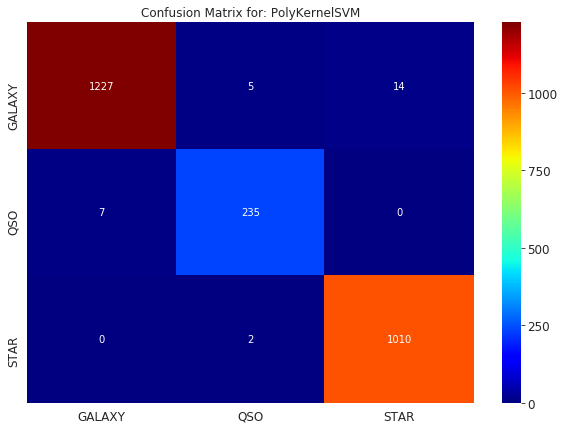

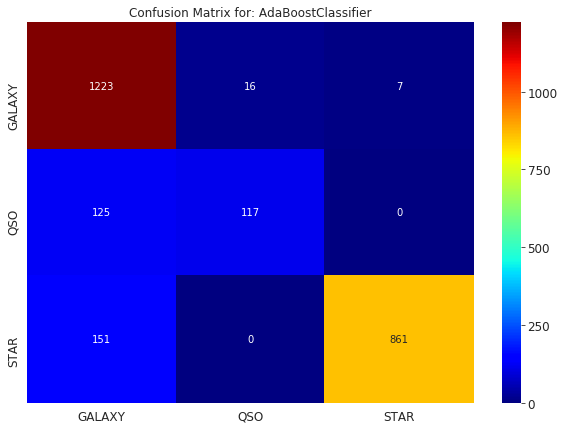

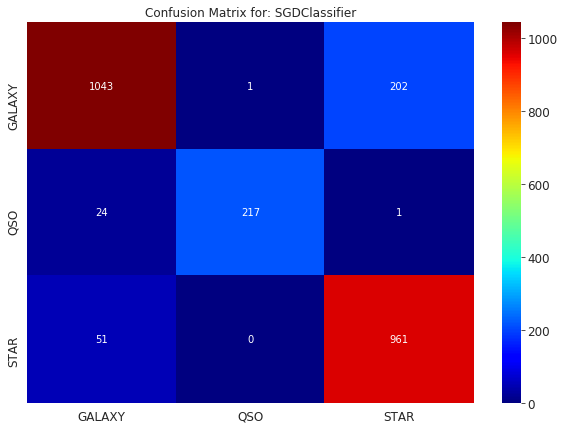

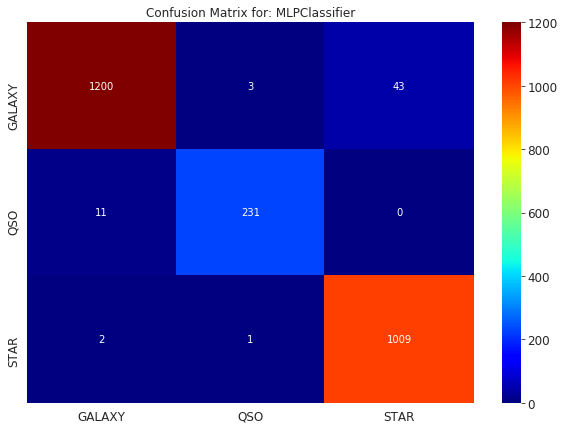

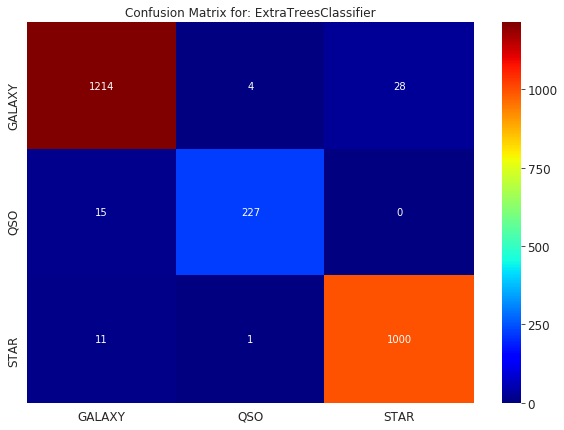

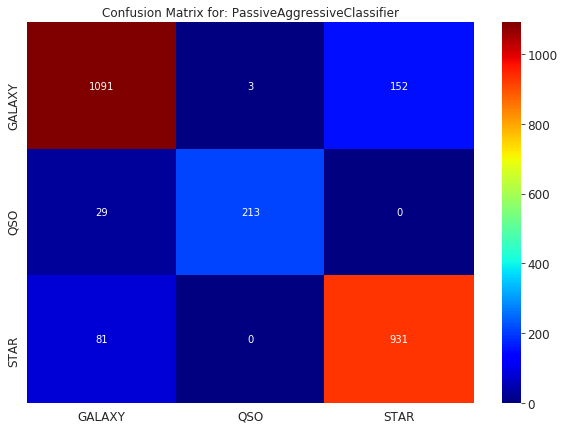

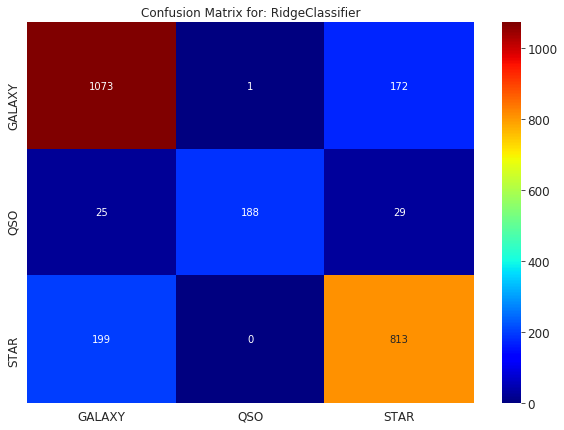

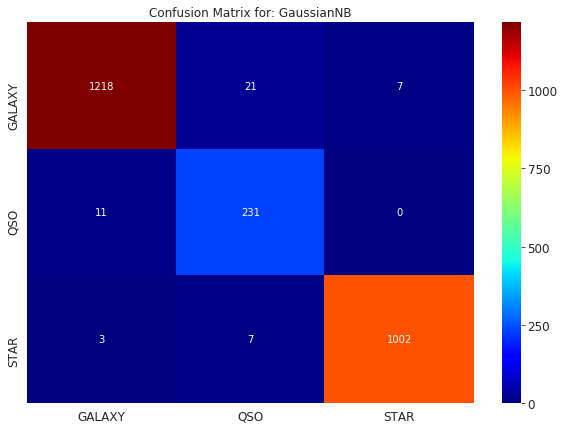

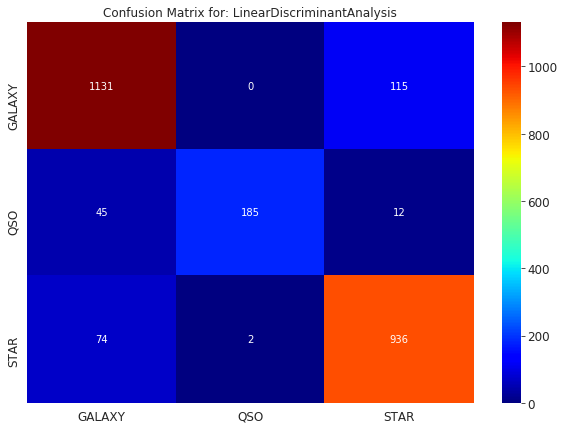

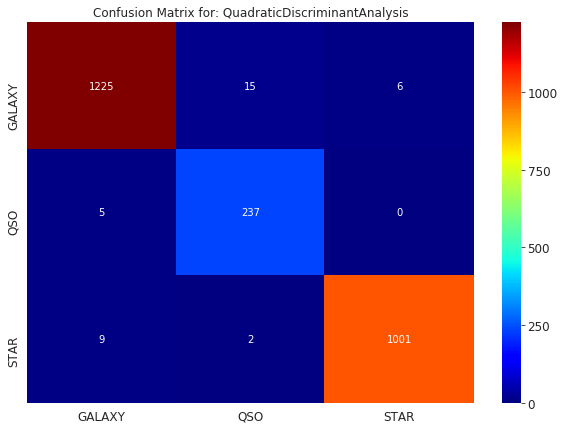

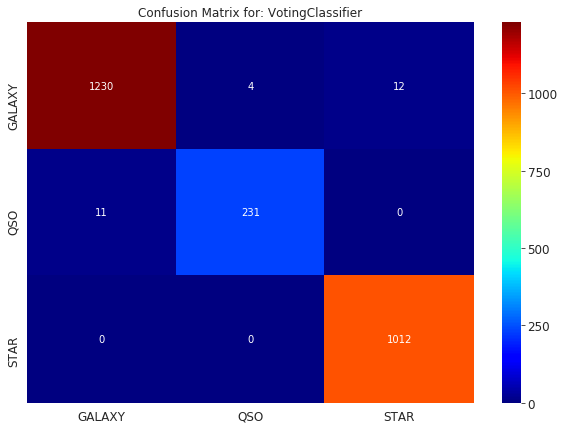

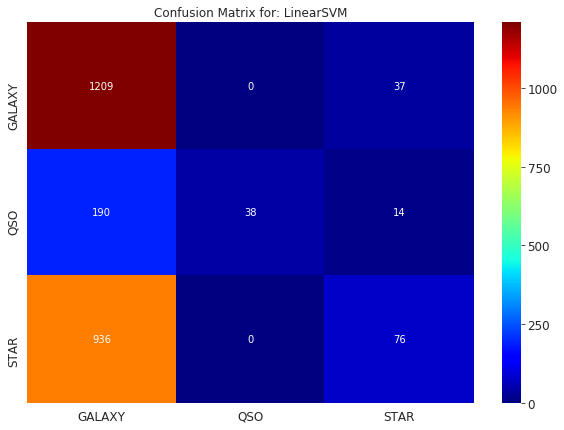

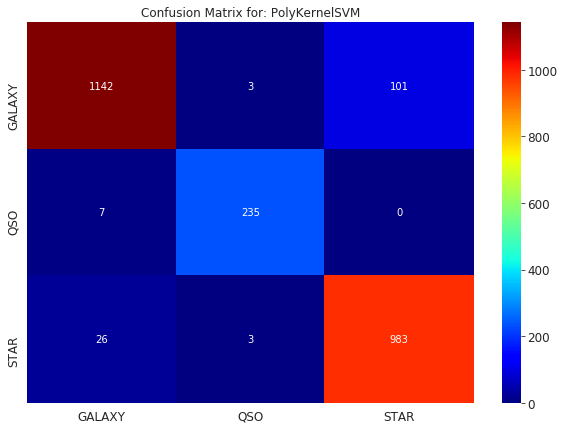

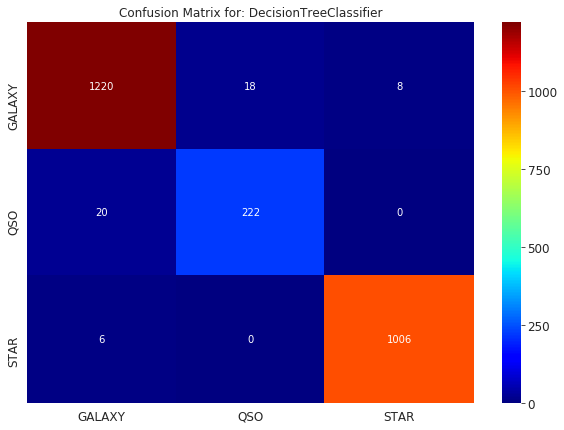

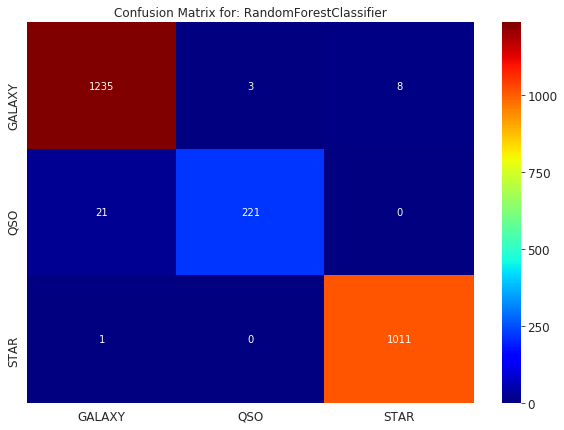

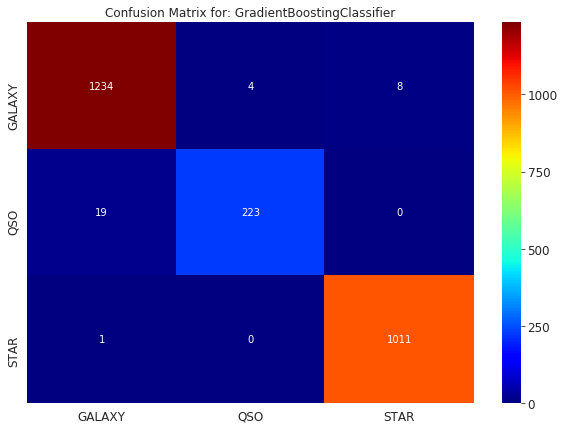

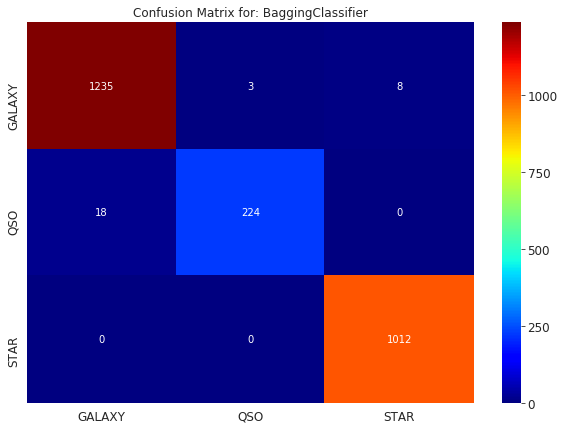

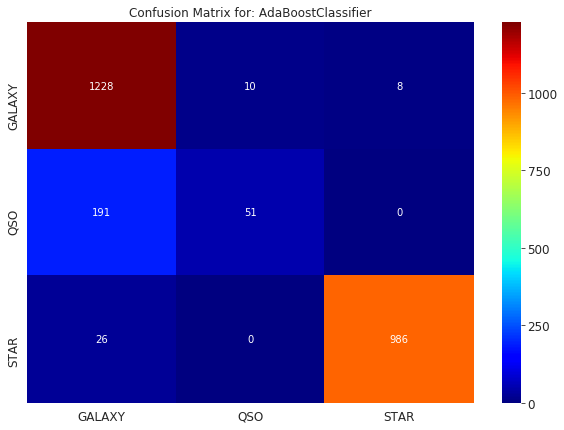

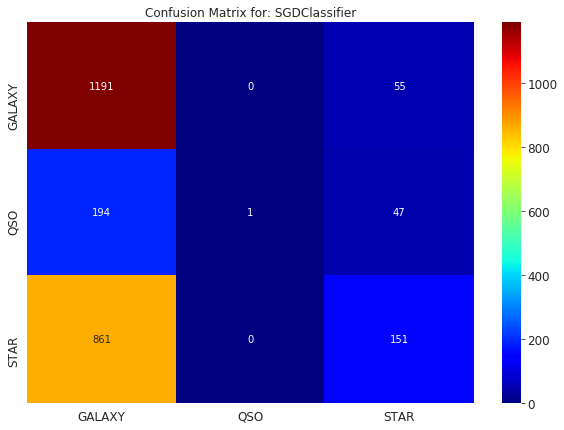

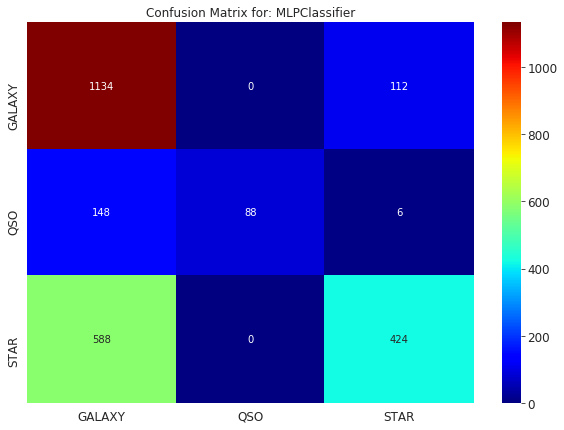

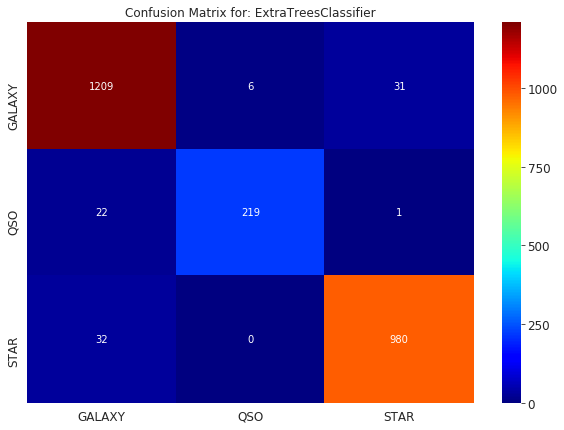

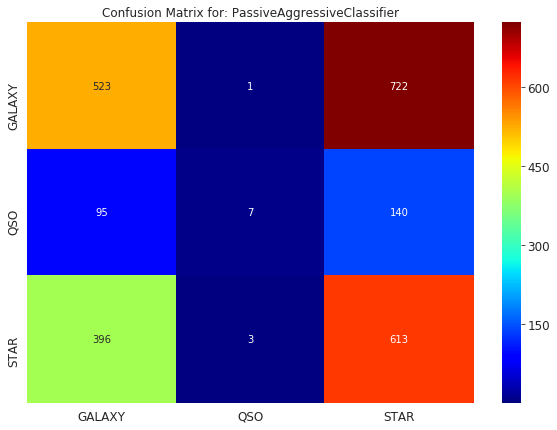

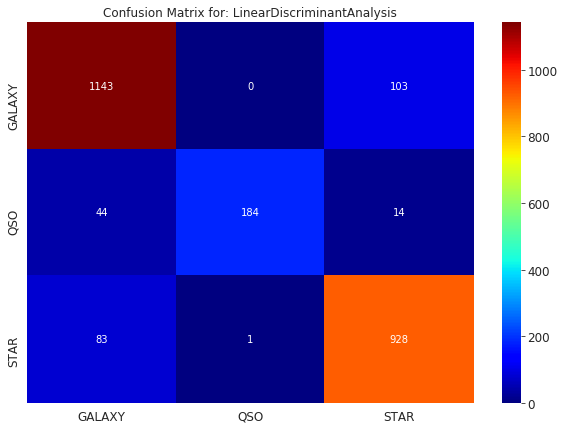

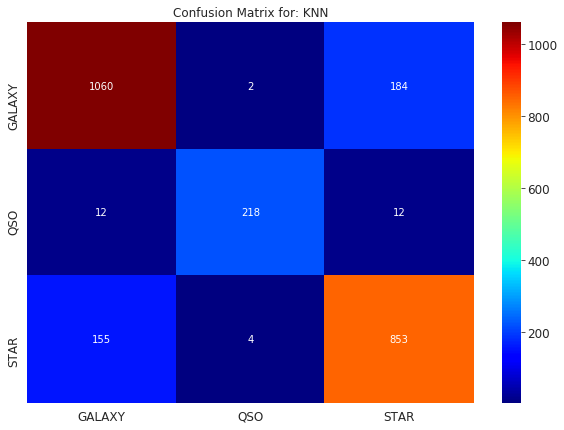

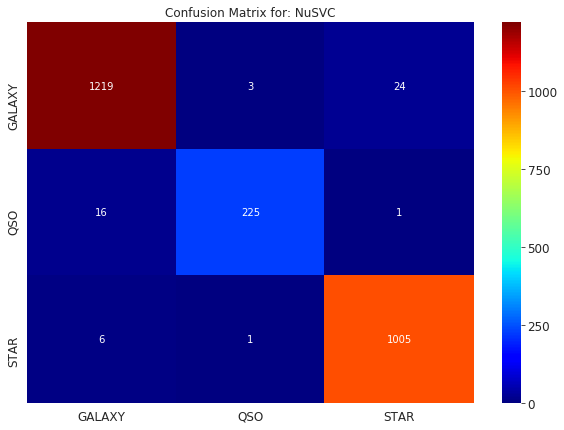

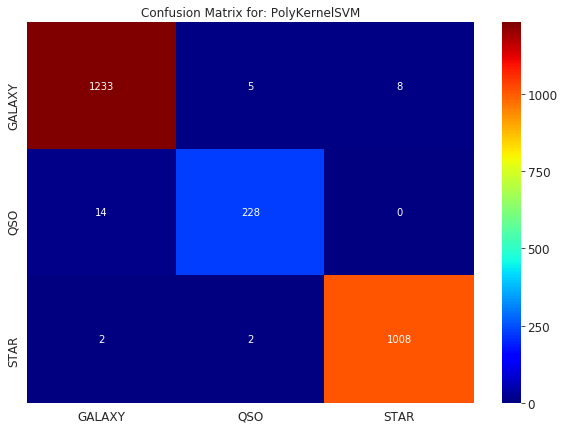

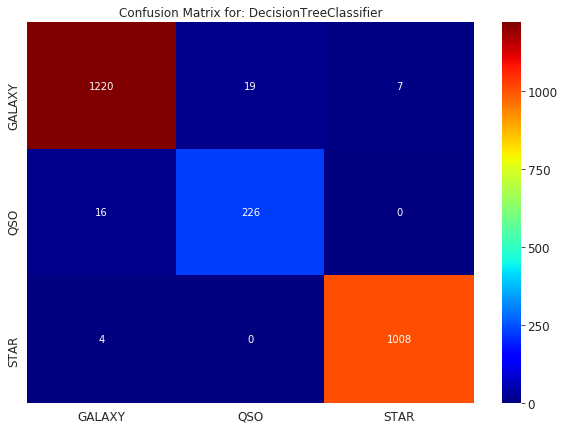

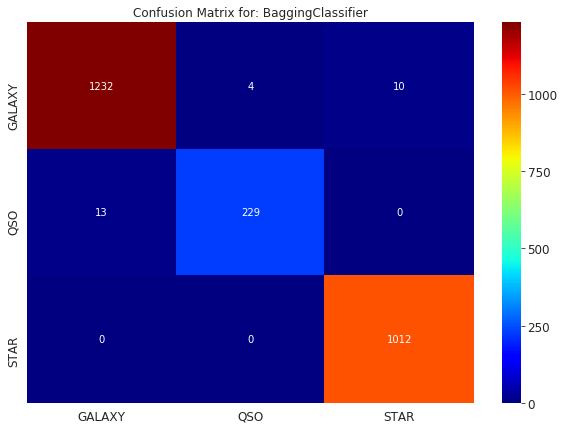

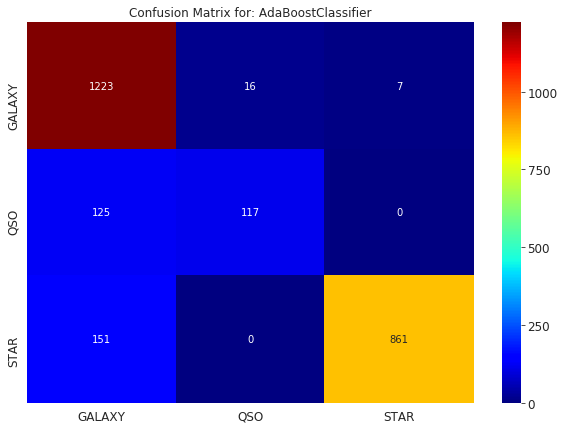

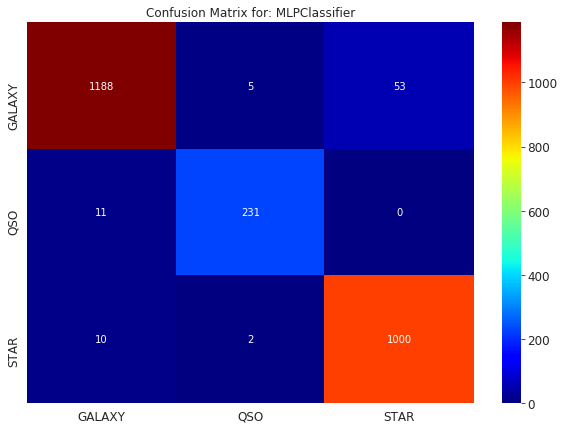

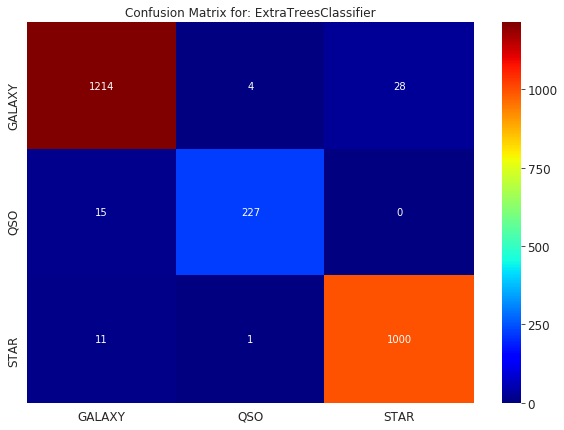

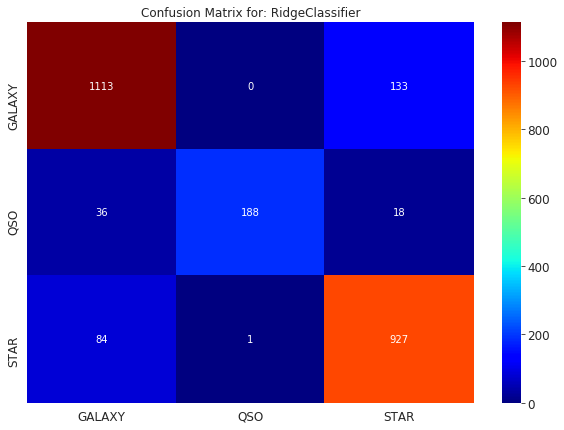

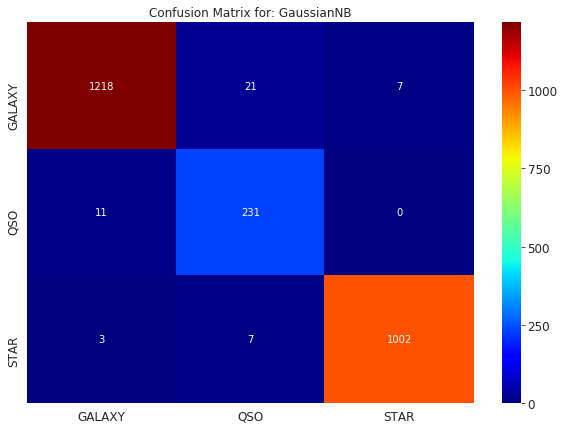

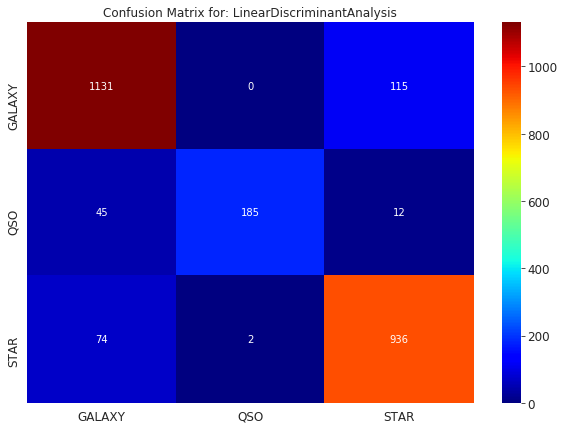

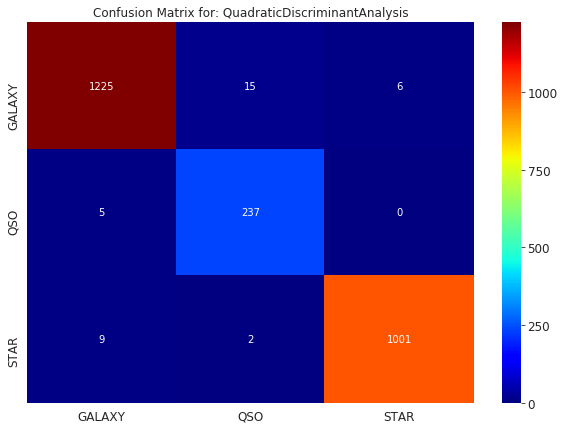

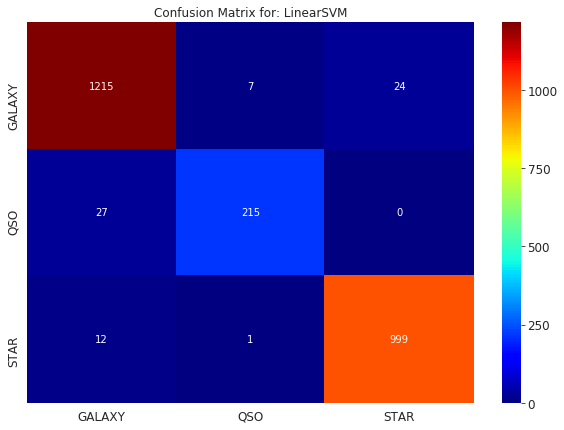

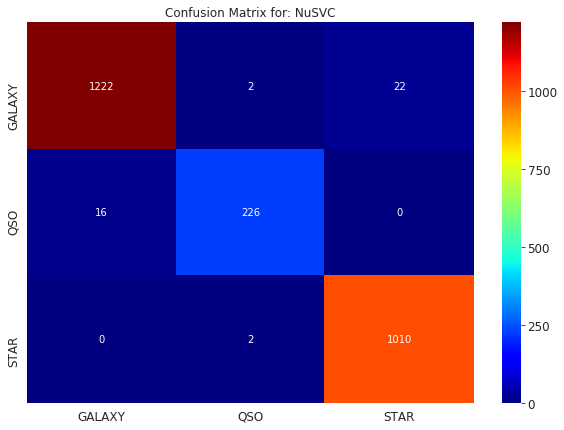

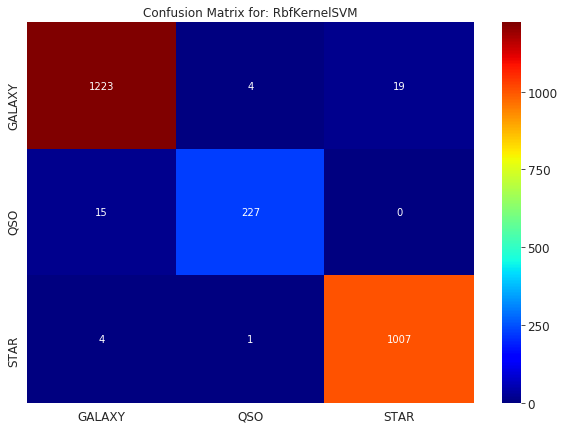

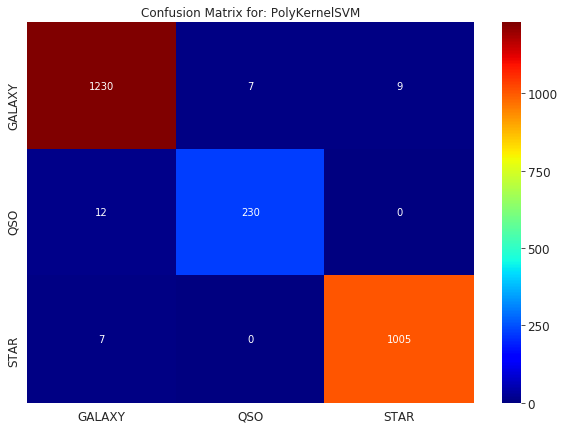

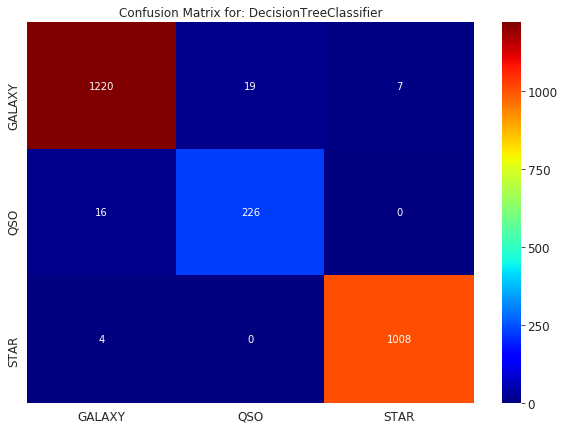

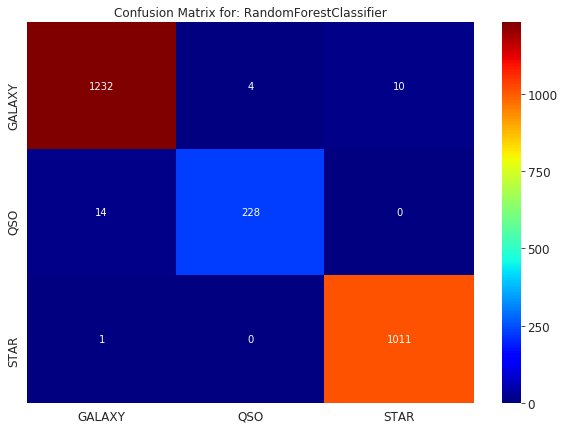

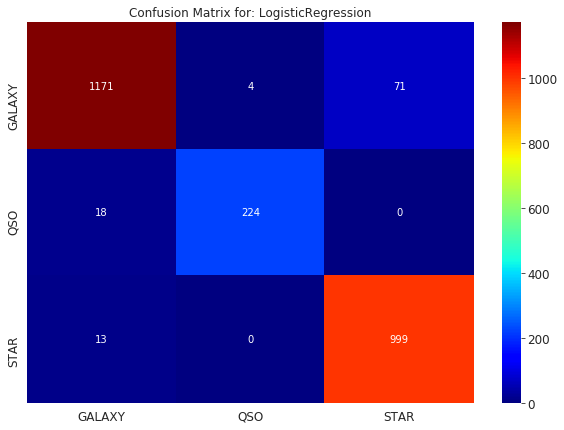

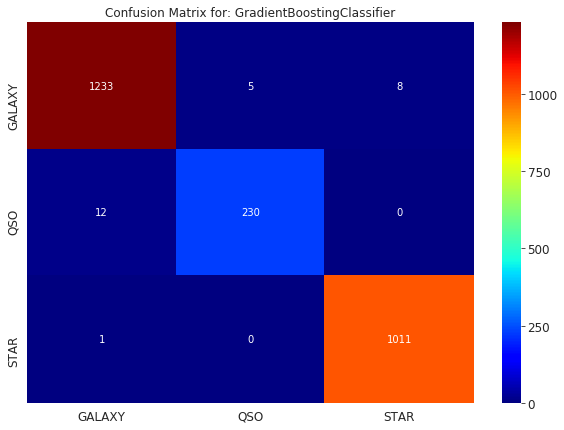

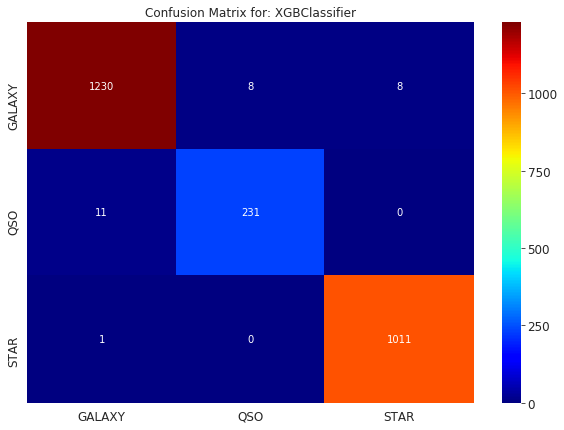

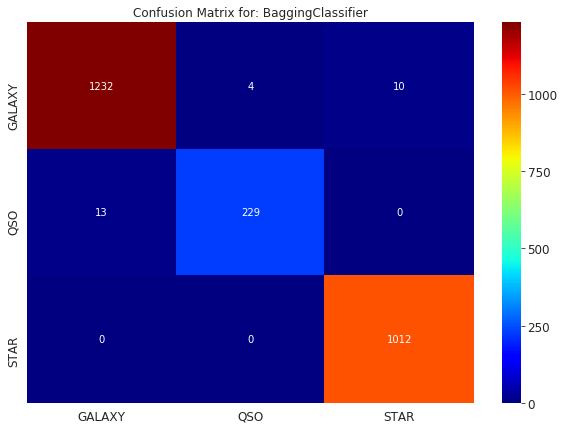

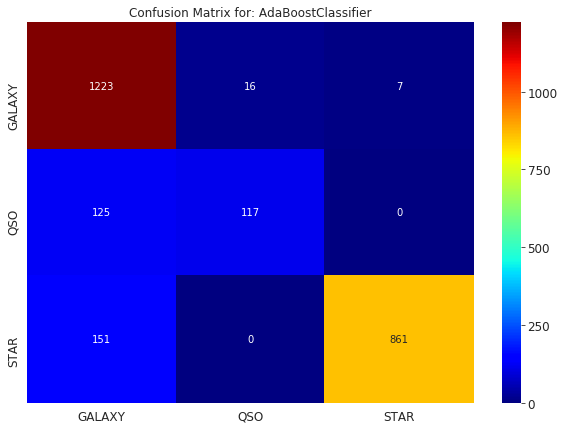

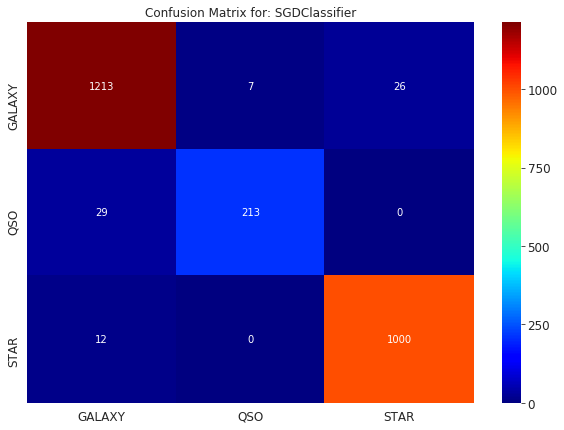

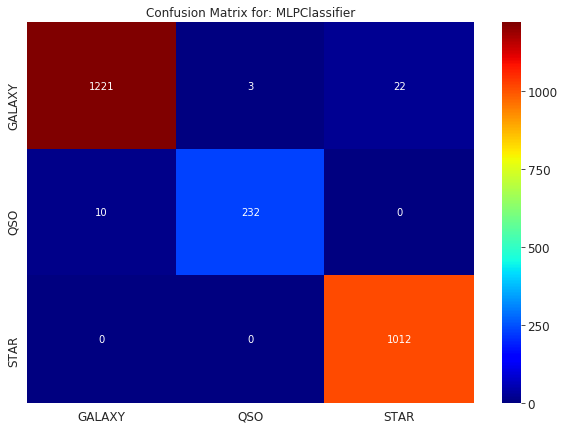

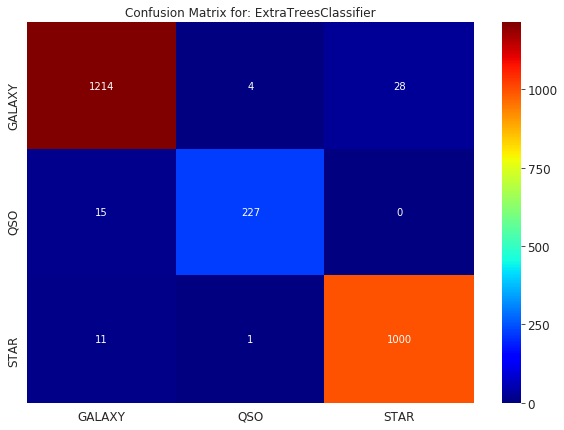

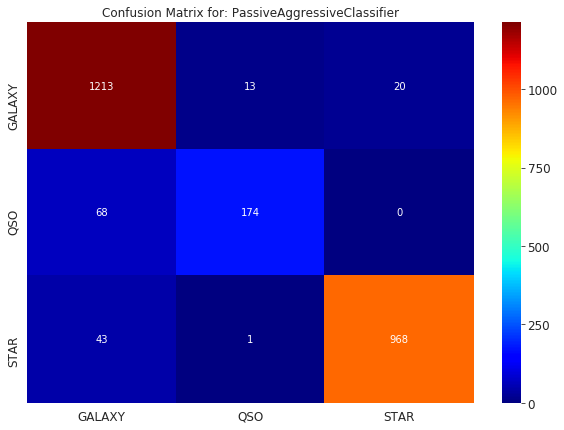

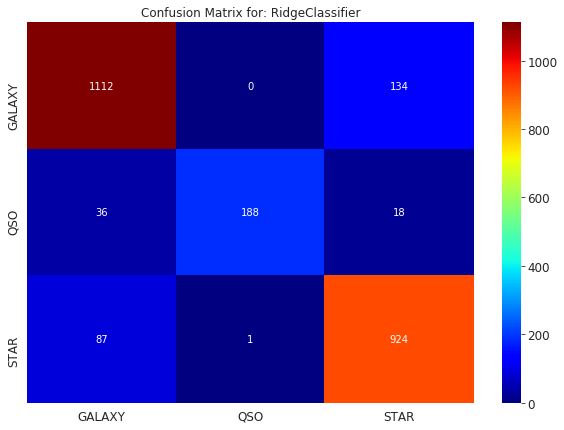

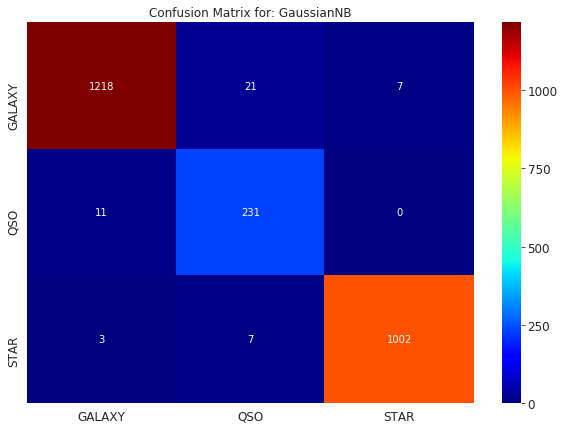

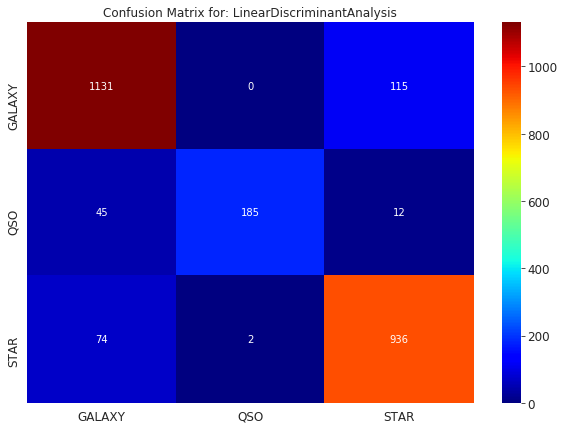

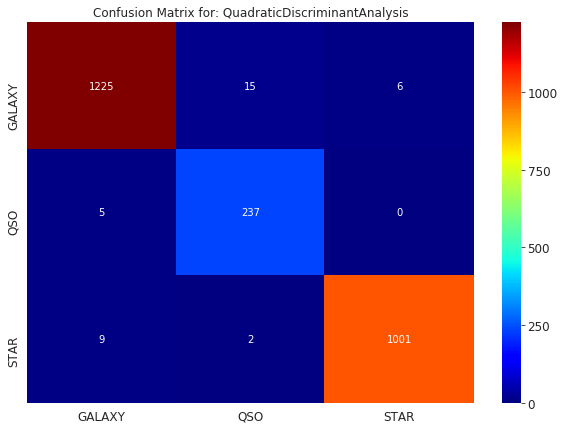

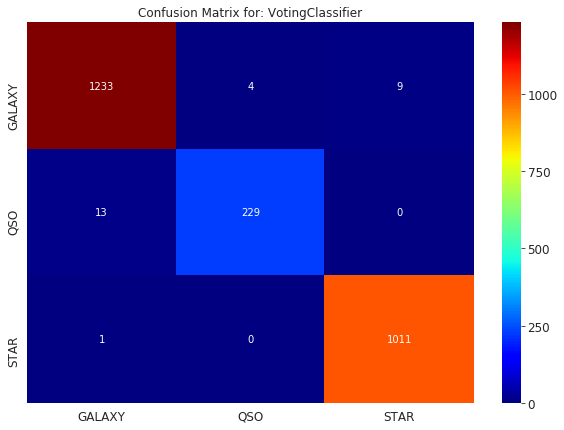

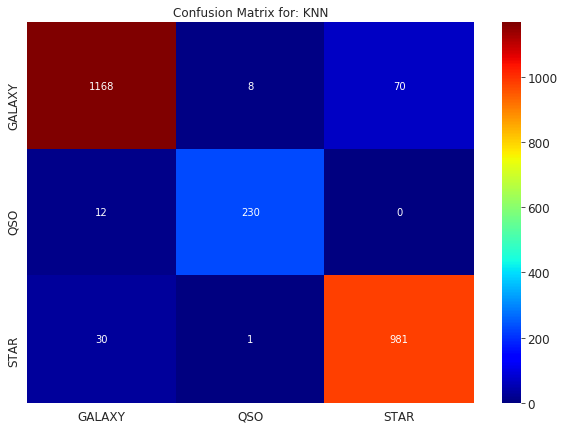

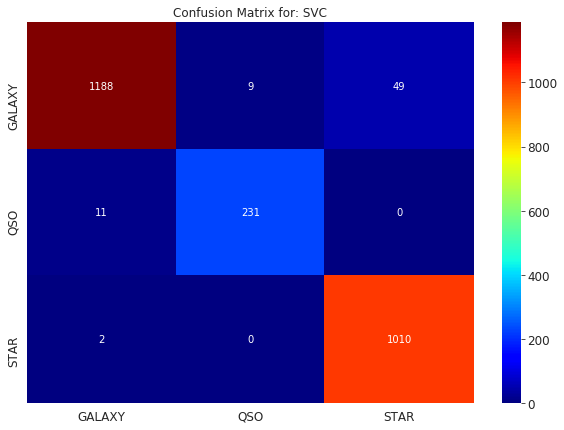

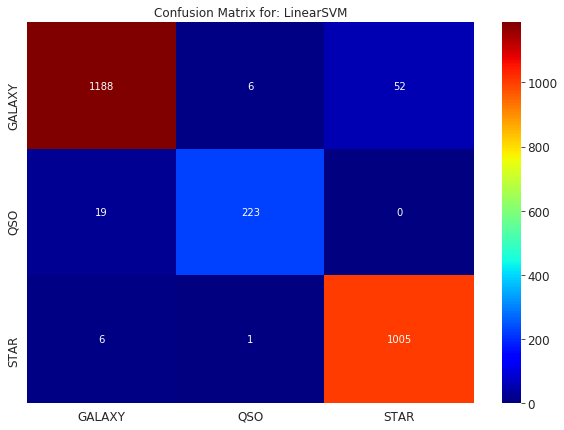

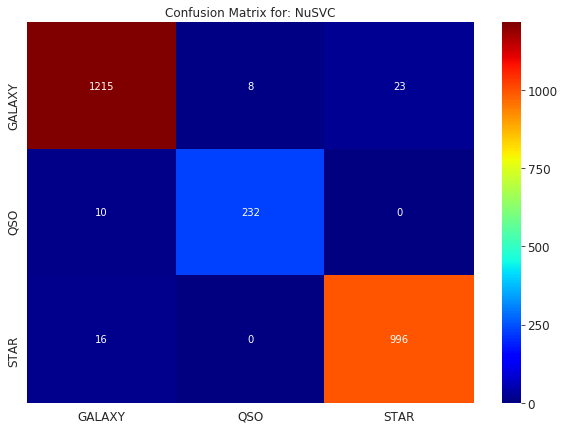

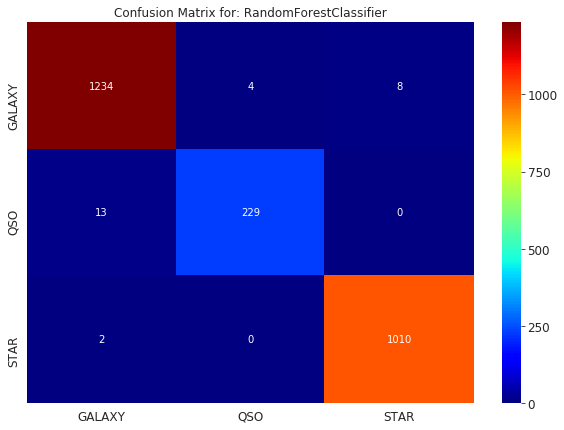

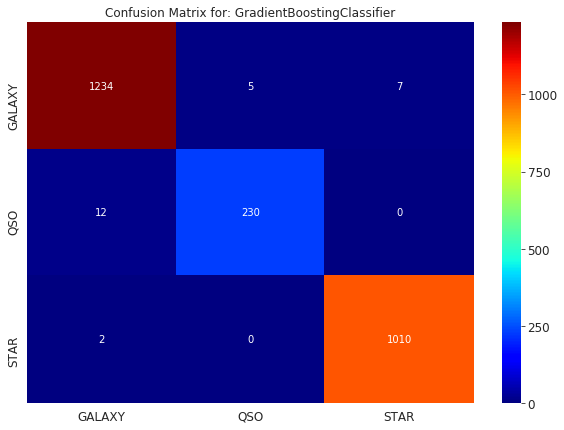

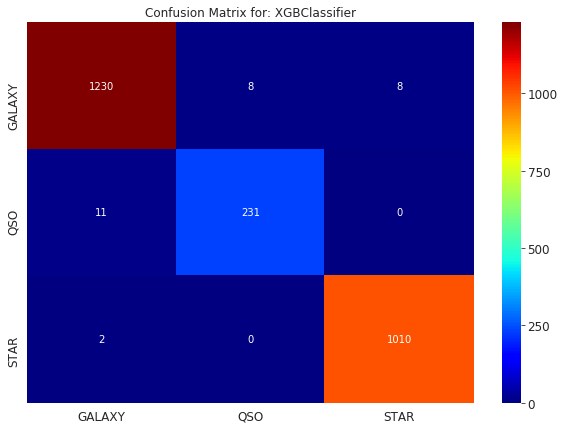

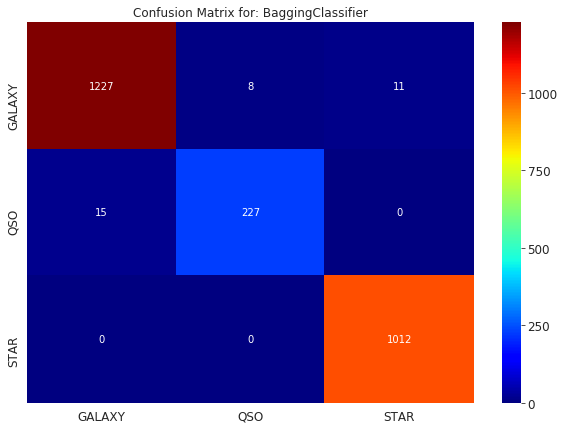

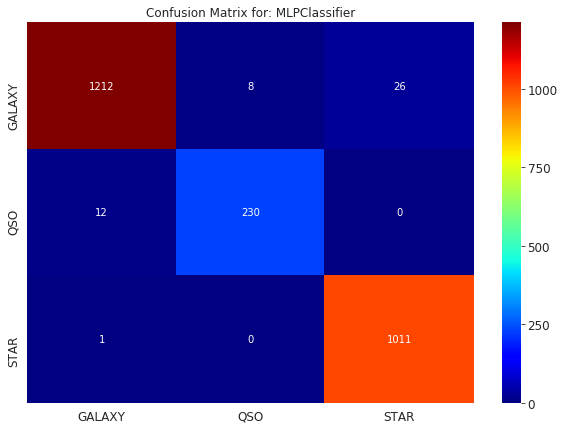

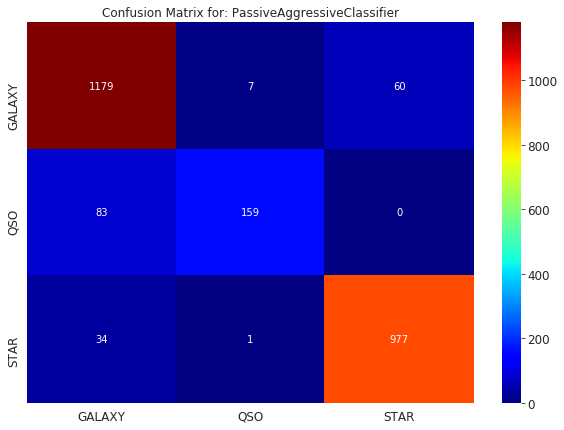

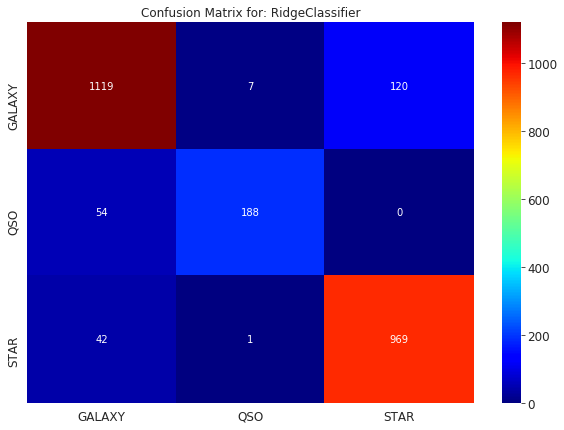

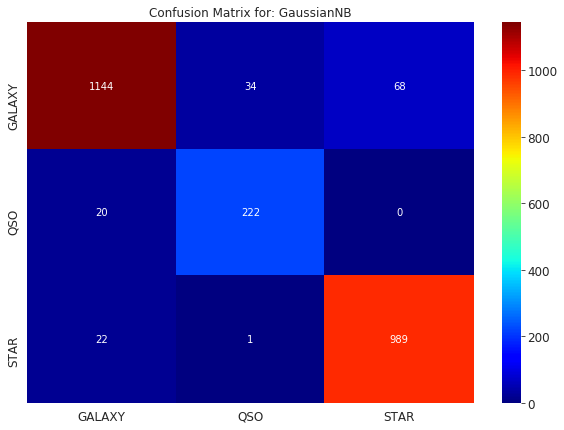

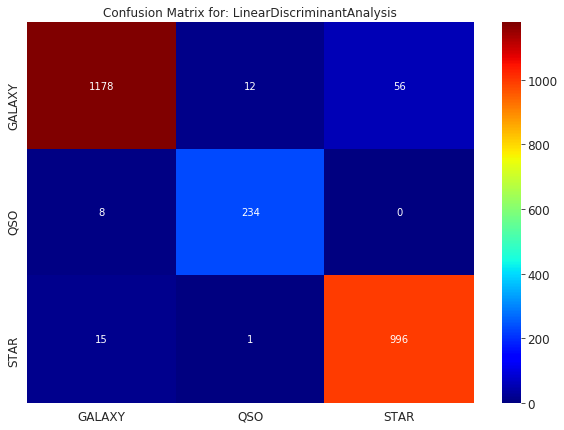

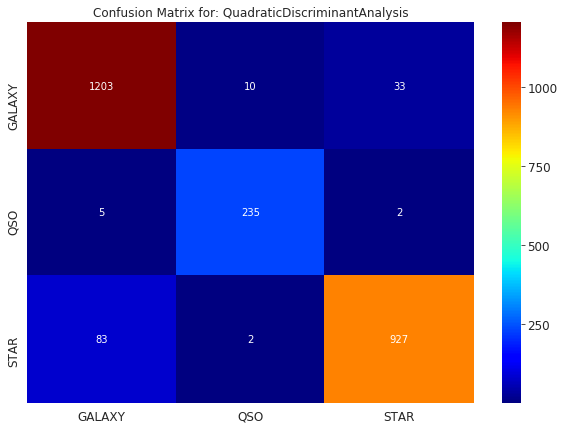

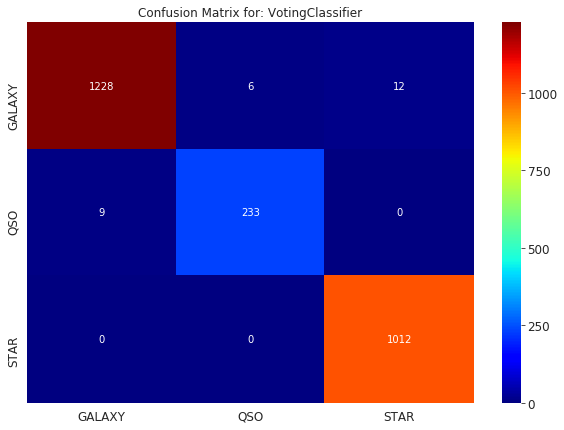

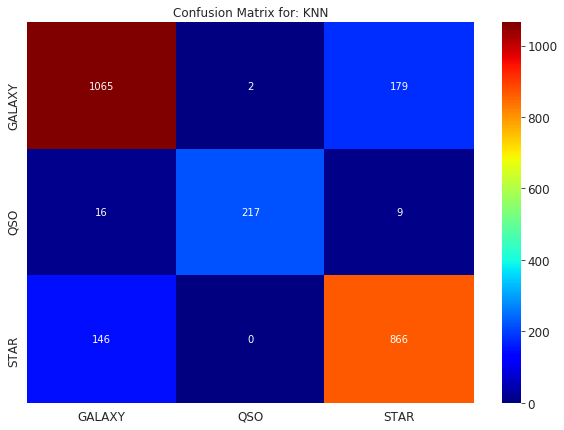

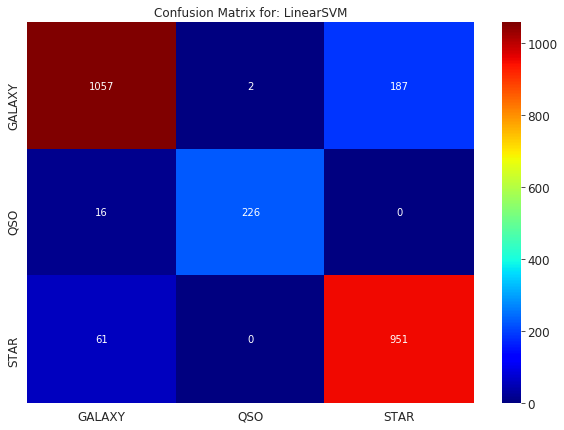

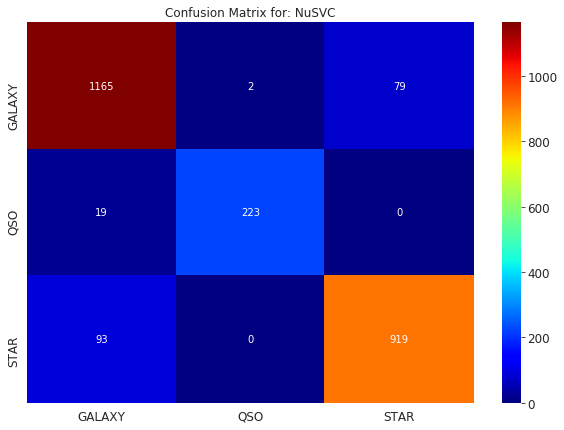

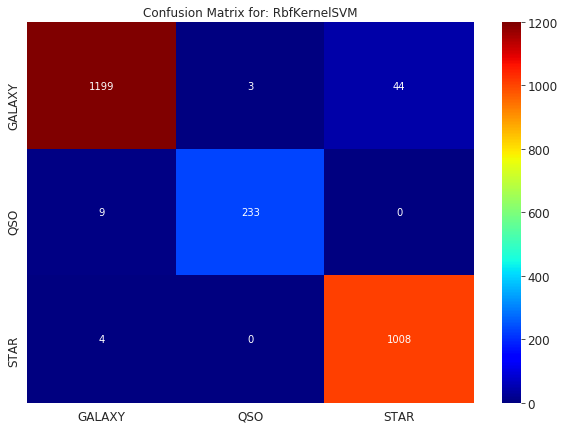

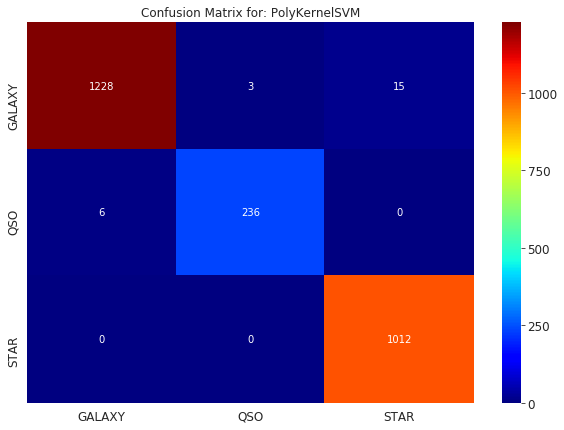

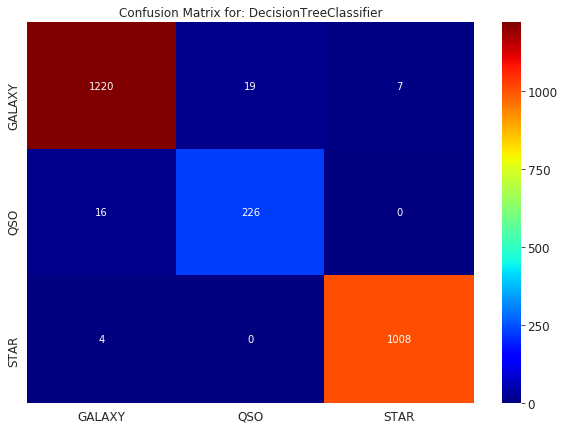

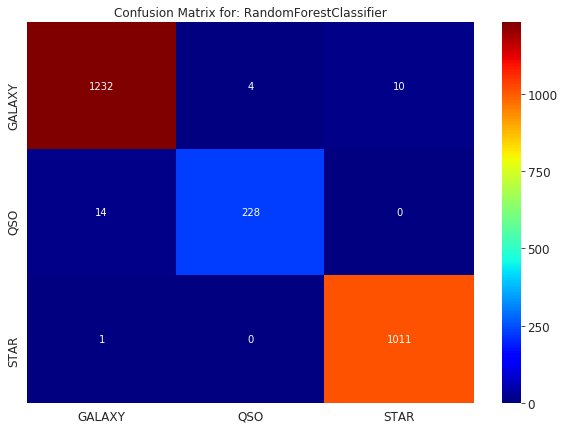

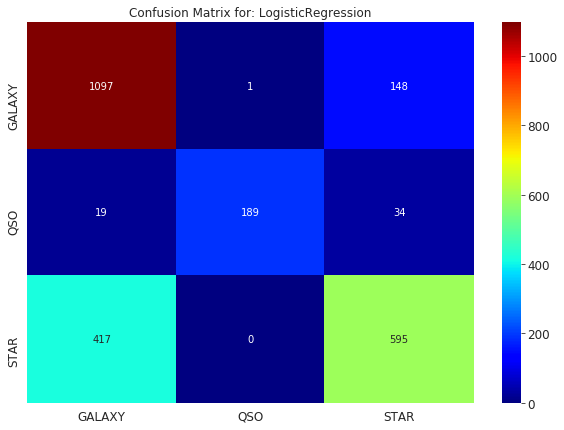

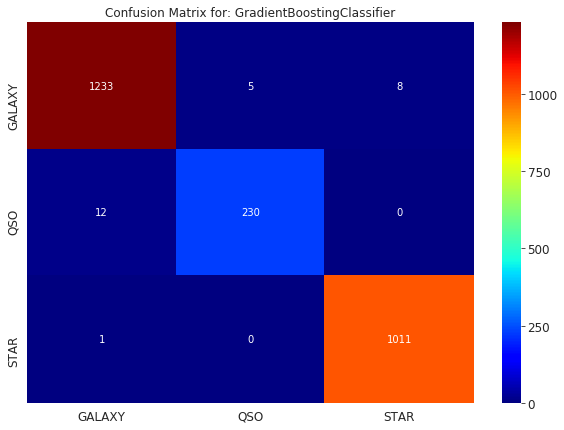

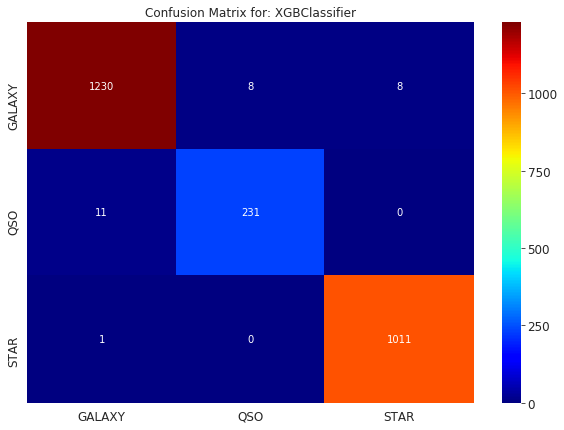

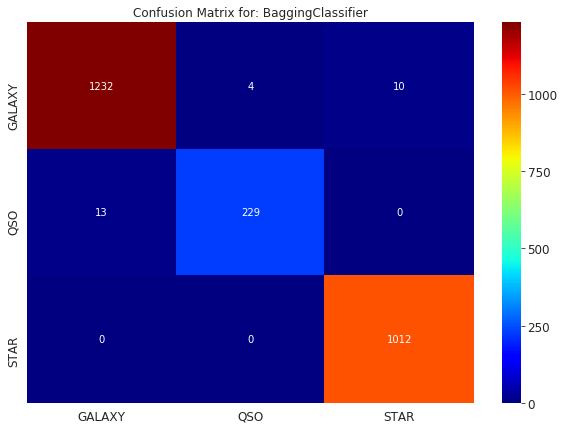

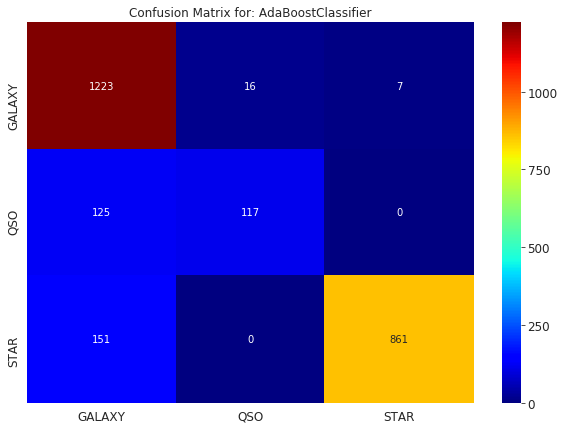

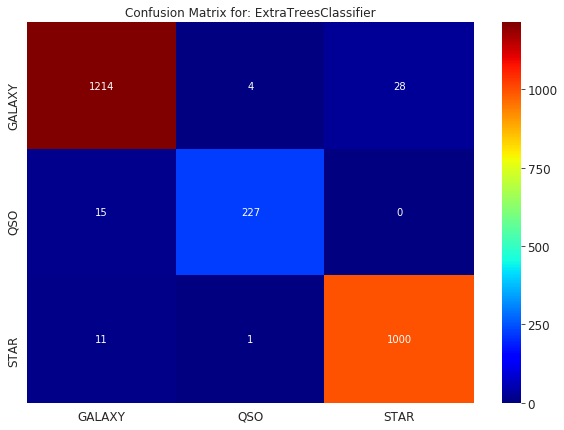

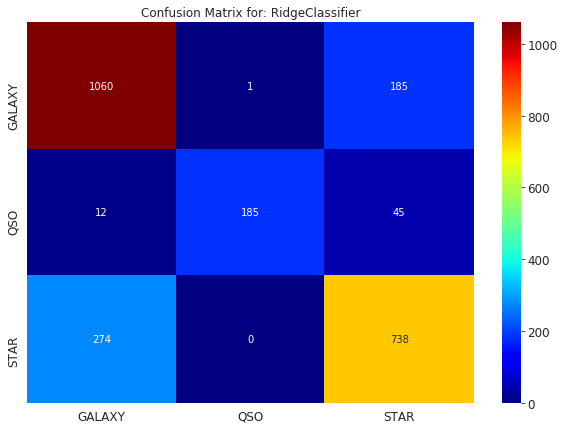

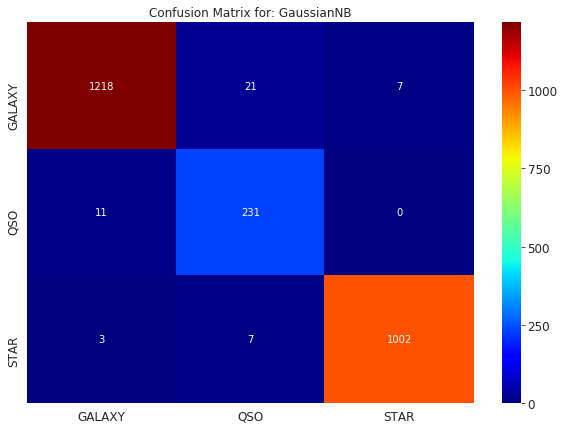

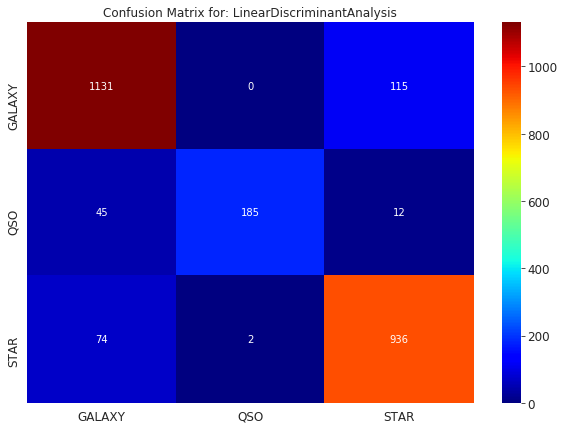

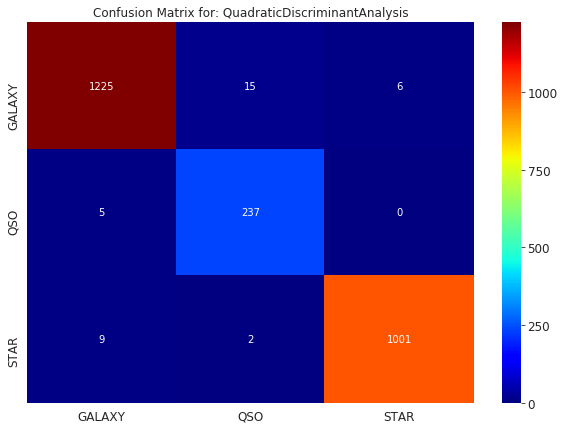

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)